In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.lax as lax
from jax import random
from jax.random import PRNGKey, normal
import matplotlib.pyplot as plt
from functools import partial
from jax import vmap
from jax.tree import map
import time
import optax

In [2]:
def initial_mask(L, size_f, dtype=jnp.float32):
    shift = int((L-1)/2)
    A = jnp.zeros((size_f, L+1, L+1), dtype=dtype)
    A1 = jnp.transpose(A, (0, 2, 1))
    A2 = A[:,::-1, :]
    A3 = A[:, :, ::-1]
    A4 = A[:, ::-1, ::-1]
    A5 = A1[:, :, ::-1]
    A6 = A1[:, ::-1, :]
    A7 = A1[:, ::-1, ::-1]
    mask = (A+A1+A2+A3+A4+A5+A6+A7)/8
    return jnp.roll(mask[:, :-1, :-1], (shift, shift), axis=(1, 2))

In [3]:
@jax.jit
def phi4_action(phi, m2, lam):
    """Compute the Euclidean action for the scalar phi^4 theory.

    The Lagrangian density is kin(phi) + m2 * phi + l * phi^4

    Args:
        phi: Single field configuration of shape L^d.
        m2: Mass squared term (can be negative).
        lam: Coupling constant for phi^4 term.

    Returns:
        Scalar, the action of the field configuration..
    """

    a = m2 * phi ** 2
    if lam is not None:
        a += lam * phi ** 4
    # Kinetic term
    a += jnp.sum(jnp.array([phi*(phi - jnp.roll(phi, 1, d)/2 - jnp.roll(phi, -1, d)/2)  for d in range(len(phi.shape))]))

    return jnp.sum(a)

@jax.jit
def diff_phi4_action(phi, m2, lam):
    a = 2 * m2 * phi
    if lam is not None:
        a += 4 * lam * phi ** 3
    for d in range(len(phi.shape)):
        a += 2*phi - jnp.roll(phi, 1, d) - jnp.roll(phi, -1, d)
    return a


In [4]:
def compute_ess(logp, logq):
    logw = logp - logq
    log_ess = 2 * jax.scipy.special.logsumexp(logw, axis=0) - jax.scipy.special.logsumexp(2 * logw, axis=0)
    ess_per_cfg = jnp.exp(log_ess) / len(logw)
    return ess_per_cfg

In [5]:
def normal_pdf(x):
    """Calculate the PDF of a standard normal distribution."""
    return (1 / jnp.sqrt(2 * jnp.pi)) * jnp.exp(-0.5 * x ** 2)

def get_batch(num_samples, L, seed):
    #   Generate a batch of samples from a standard normal distribution.
    key = PRNGKey(seed)
    x = normal(key, (num_samples, L, L))
    logp_x= jnp.sum(jnp.log(normal_pdf(x)), axis=(1, 2)) # log probability of each sample
    diff_logp_x =  x * ( -1 / jnp.sqrt(2 * jnp.pi)) # gradient of log probability
    
    return(x, logp_x, diff_logp_x)



In [6]:
#@partial(jax.custom_vjp, nondiff_argnums=(0, 1))
def mul_const_tree(tree, const):
    """Multiplies every element in the pytree by a constant."""
    return jax.tree.map(lambda x: x * const, tree)

def add_trees(*trees):
    """Adds multiple pytrees together."""
    return jax.tree.map(lambda *xs: sum(xs), *trees)
    
@jax.jit
def rk4_odeint (step_size, input_, ts, W_a, omega_a):
    def func_(input_, t,  W_a, omega_a):
        x, logp_x, d_logp_x, diff_xf_W, diff_xf_omega = input_
        #jax.debug.print("W_a:{}", W_a.shape)
        W = W_t(W_a, t)
        omega = omega_t(omega_a, t)
        a_w = jnp.concatenate((jnp.array([1., ]), jnp.sin((jnp.arange(W_a.shape[0]-1)+1)*t)), axis = 0)
        a_omega = jnp.concatenate((jnp.array([1., ]), jnp.sin((jnp.arange(omega_a.shape[0]-1)+1)*t)), axis = 0)
        return (jnp.sum(jnp.fft.ifft2(jnp.fft.fft2(W)*jnp.fft.fft2(jnp.sin(omega.reshape(-1, 1, 1)* x))).real, axis = 0), 
                jnp.sum(W[:,0,0].reshape(-1, 1, 1)*(omega.reshape(-1, 1, 1)*jnp.cos(omega.reshape(-1, 1, 1)*x))),
                -jnp.sum(omega.reshape(-1, 1, 1)*jnp.cos(omega.reshape(-1, 1, 1)*x)*jnp.fft.ifft2(jnp.flip(jnp.roll(jnp.fft.fft2(W), (-1, -1), (-1, -2)), (-1, -2))*jnp.fft.fft2(d_logp_x)).real, axis = 0)+jnp.sum(W[:,0,0].reshape(-1, 1, 1)*((omega**2).reshape(-1, 1, 1)*jnp.sin(omega.reshape(-1, 1, 1)*x)), axis = 0),
                a_w.reshape(-1, 1, 1, 1)*jnp.sin(omega.reshape(-1, 1, 1)*x),
                a_omega.reshape(-1, 1, 1, 1)*jnp.fft.ifft2(jnp.fft.fft2(W)*jnp.fft.fft2(x*jnp.cos(omega.reshape(-1, 1, 1)*x))).real)
    

    """Integrate a system of ODEs using the 4th order Runge-Kutta method."""
    def step_func(cur_y, cur_t, dt):
        """Take one step of RK4."""
        k1 = func(cur_y, cur_t, W_a, omega_a)
        k2 = func(add_trees(cur_y, mul_const_tree(k1, dt * 0.4)), cur_t + dt * 0.4, W_a, omega_a)
        k3 = func(add_trees(cur_y, mul_const_tree(k1, dt * 0.29697761), mul_const_tree(k2, dt * 0.15875964)), cur_t + dt * 0.45573725, W_a, omega_a)
        k4 = func(add_trees(cur_y, mul_const_tree(k1, dt * 0.21810040), mul_const_tree(k2, -dt * 3.05096516), mul_const_tree(k3, dt * 3.83286476)), cur_t + dt, W_a, omega_a)

        final_step = add_trees(
            mul_const_tree(k1, dt * 0.17476028),
            mul_const_tree(k2, -dt * 0.55148066),
            mul_const_tree(k3, dt * 1.20553560),
            mul_const_tree(k4, dt * 0.17118478)
        )
        return final_step

    def cond_fun(carry):
        """Check if we've reached the last timepoint."""
        cur_y, cur_t = carry
        return cur_t < ts[1]

    def body_fun(carry):
        """Take one step of RK4."""
        cur_y, cur_t = carry
        next_t = jnp.minimum(cur_t + step_size, ts[1])
        dt = next_t - cur_t
        dy = step_func(cur_y, cur_t, dt)
        return add_trees(cur_y, dy), next_t
    
    func = vmap(func_, in_axes=(0, None, None, None))
    init_carry = (input_, ts[0])
    y1, t1 = jax.lax.while_loop(cond_fun, body_fun, init_carry)
    return y1
'''
input: (x, log(p(x)), dlog(p(x))/dx), t, W, omega
return: f(x, t, W, omega), tr(df/dx), dln(p(x))/dx, df/dW, df/domega
'''


@jax.jit
def forward(x0, log_px0, diff_logp_x0, diff_xf_W_t0, diff_xf_omega_t0, W, omega, t0, tf, dt):
    
    xf, logp_prob, diff_logp_x, int_diff_xf_W, int_diff_xf_omega = rk4_odeint(dt, (x0, log_px0, diff_logp_x0, diff_xf_W_t0, diff_xf_omega_t0), jnp.array([t0, tf]), W, omega)
    # Mean is taken over the batch dimension to get the avarged gradient
    #print("int_diff_xf_W", int_diff_xf_W.shape)
    #print("diff_logp_x", diff_logp_x.shape)
    
    
    return xf, logp_prob, diff_logp_x, int_diff_xf_W, int_diff_xf_omega 
    
def W_t(a, t):
    return a[0]+jnp.sum(a[1:]*(jnp.sin((jnp.arange(a.shape[0]-1)+1)*t).reshape(-1, 1, 1, 1)), axis = 0)
def omega_t(a, t):
    return a[0]+jnp.sum(a[1:]*(jnp.sin((jnp.arange(a.shape[0]-1)+1)*t)).reshape(-1, 1), axis = 0)

In [7]:
L = 4
lr = 0.01
seed = 0 
train_steps = 500
num_samples = 64
f = 8
N_samples = 1000
t0, tf, dt = 0., 1., 0.02
m2 = -1
lam = 1
t_kernel = 16
W_a = jnp.zeros((t_kernel, f, L, L))
omega_0 = jnp.arange(f)+0.5
omega_a = jnp.concatenate((omega_0[None, :], jnp.zeros((t_kernel-1, f))), axis = 0) 
solver = optax.adam(learning_rate=lr)
params = (W_a, omega_a)
opt_state = solver.init(params)
batch_phi4 = jax.jit(vmap(partial(phi4_action, m2 = m2, lam = lam), in_axes=(0, )))
batch_diff_phi4 = jax.jit(vmap(partial(diff_phi4_action, m2 = m2, lam = lam), in_axes=(0, )))

for i in range (train_steps):
    t0_ = time.time()
    x0, logp_x0, dlogp_x0 = get_batch(num_samples, L, seed)
    diff_xf_W_t0 = jnp.zeros_like(jnp.repeat(W_a[None, :], num_samples, axis = 0))
    diff_xf_omega_t0 = jnp.zeros_like(jnp.repeat(W_a[None, :], num_samples, axis = 0))
    xf, logp_prob, diff_logp_x, int_diff_xf_W, int_diff_xf_omega  = rk4_odeint(dt, (x0, logp_x0, dlogp_x0, diff_xf_W_t0, diff_xf_omega_t0), jnp.array([t0, tf]), W_a, omega_a)
    diff_logp_x += batch_diff_phi4(xf)
    grad_w = jnp.mean(jnp.fft.ifft2(jnp.flip(jnp.roll(jnp.fft.fft2(int_diff_xf_W), (-1, -1), axis=(-2, -1)), (-2, -1)) * jnp.fft.fft2(diff_logp_x)[:, None, None]).real, axis = 0)
    grad_omega = jnp.mean(jnp.sum(diff_logp_x[:, None, None]*int_diff_xf_omega, axis = (-2, -1)), axis = 0)
    logp_xf = logp_x0 - logp_prob
    logp = -batch_phi4(xf)
    logp_x = logp_xf-logp
    loss = logp_x.mean(0)
    #print("W", W.shape, "omega", omega.shape)
    #print("grad_w", grad_w.shape, "grad_omega", grad_omega.shape)
    updates, opt_state = solver.update((grad_w, grad_omega), opt_state, params)
    params = optax.apply_updates(params, updates)
    W, omega = params
    if i % 10 == 0:
        print("ess:", compute_ess(logp, logp_xf))  
        print("itert: ", time.time() - t0_)
        print('Iter: {}, loss: {:.4f}\n'.format(i, loss.item()))
        #print("grad_w", grad_w)
        #print("grad_omega", grad_omega)
    seed += 1
    #print(jnp.linalg.norm(W-W_a), jnp.linalg.norm(omega-omega_a))

ess: 0.015625
itert:  2.563152551651001
Iter: 0, loss: 521.7842
ess: 0.015727377
itert:  0.26273012161254883
Iter: 10, loss: 570.9979


KeyboardInterrupt: 

In [430]:
key = PRNGKey(0)
a = random.normal(key, (3,))
b = jnp.ones((4 ,2, 5))
(a.reshape(-1, 1, 1, 1)*b).shape

(3, 4, 2, 5)

In [439]:
jnp.concatenate((jnp.array([1,]), jnp.sin(jnp.arange(3)*0.5)), axis = 0)

Array([1.        , 0.        , 0.47942555, 0.84147096],      dtype=float32, weak_type=True)

In [210]:
x0, logp_x0 = get_batch(num_samples, L, seed)
omega = jnp.arange(2)
print(omega[:, None].shape, x0[None, :].shape)
(omega * (omega.reshape(-1, 1, 1, 1) * x0)).shape

(2, 1) (1, 3, 4, 4)


ValueError: Incompatible shapes for broadcasting: shapes=[(2,), (2, 3, 4, 4)]

In [162]:
import jax.numpy as jnp
import jax

# Define a multidimensional nested pytree
pytree = {
    'first': jnp.array([[1, 2], [3, 4]]),
    'second': (jnp.array([5, 6]), jnp.array([7, 8])),
    'third': {'a': jnp.array([9, 10]), 'b': jnp.array([11, 12])}
}

# Constant to multiply with
constant = 3

# Function to multiply an array by a constant
def multiply_by_constant(array):
    return constant * array

# Multiply every element in the pytree by the constant
result = jax.tree_map(multiply_by_constant, pytree)

print(result)


{'first': Array([[ 3,  6],
       [ 9, 12]], dtype=int32), 'second': (Array([15, 18], dtype=int32), Array([21, 24], dtype=int32)), 'third': {'a': Array([27, 30], dtype=int32), 'b': Array([33, 36], dtype=int32)}}


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6416\3538021090.py:19: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  result = jax.tree_map(multiply_by_constant, pytree)


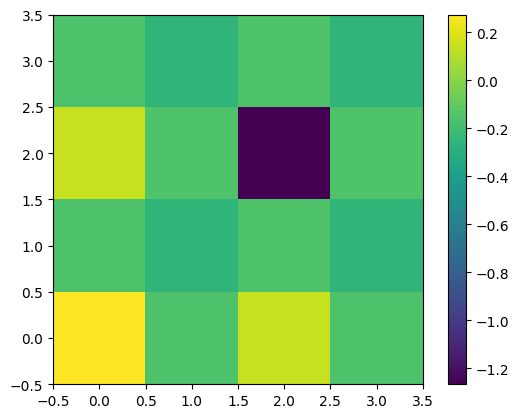

In [69]:

def serial_sample_generator(key, batch_size, N_sample, L, func):
    config, logq, logp = None, None, None
    for i in range(N_sample): 
        batch_i = i % batch_size
        if batch_i == 0:
            key, subkey = random.split(key)
            x, logp_0 = get_batch(subkey, batch_size, L)
            config, log_prob = func(x)

            logq = logp_0 - log_prob
            logp = -phi4_action(config)
                
        yield config[batch_i], logq[batch_i], logp[batch_i]

def make_mcmc_ensemble(seed, batch_size, N_samples, L, func):
    history = {
        'x': [],
        'logq': [],
        'logp': [],
        'accepted': []
    }
    key = PRNGKey(seed)
    sample_gen = serial_sample_generator(key, batch_size, N_samples, L, func)
    
    for new_x, new_logq, new_logp in sample_gen:
        if len(history['logp']) == 0:
            # Always accept the first proposal; Markov chain must start somewhere
            accepted = True
        else:
            # Metropolis acceptance condition
            last_logp = history['logp'][-1]
            last_logq = history['logq'][-1]
            p_accept = jnp.exp((new_logp - new_logq) - (last_logp - last_logq))
            p_accept = jnp.minimum(1, p_accept)

            key, subkey = random.split(key)
            draw = random.uniform(subkey)  # ~ [0, 1]
            if draw < p_accept:
                accepted = True
            else:
                accepted = False
                new_x = history['x'][-1]
                new_logp = last_logp
                new_logq = last_logq

        # Update Markov chain
        history['logp'].append(new_logp)
        history['logq'].append(new_logq)
        history['x'].append(new_x)
        history['accepted'].append(accepted)
        
    return history

history = make_mcmc_ensemble(seed, batch_size, N_samples, L, func, action)
print(history)


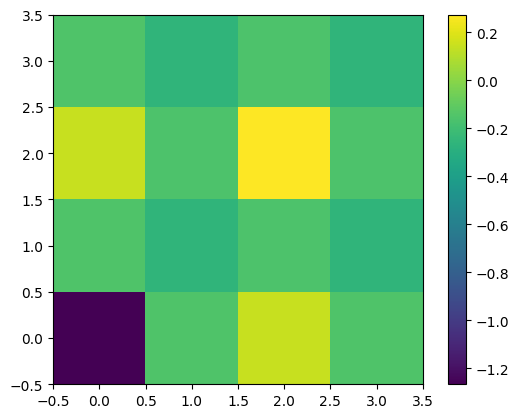

In [71]:
plt.imshow(jnp.roll(C, (2, 2), axis = (0, 1)), cmap='viridis', origin='lower')
plt.colorbar()
plt.show()

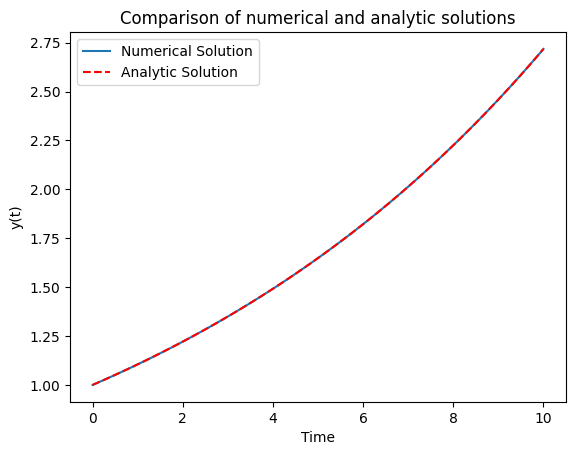

In [385]:
a = random.normal(PRNGKey(0), (5, 5))
b = random.normal(PRNGKey(2), (5, 5))
x = random.normal(PRNGKey(1), (5, 5))

In [380]:
A = jnp.zeros((5, 5, 5, 5))
#B = jnp.diag(b)
for i in range (5):
    for j in range(5):
        A = A.at[:, :, i, j].set(jnp.roll(a, (i, j), (0, 1)))

In [381]:
x.reshape(-1) @ A.reshape(25, -1)  

Array([-10.312873  ,   1.3553374 ,   8.305039  ,   2.1375406 ,
         0.41786185,   5.031165  ,   4.115156  ,  -6.0894876 ,
        -4.930898  ,  -8.026865  ,   5.453595  , -10.100704  ,
         7.485309  ,   6.9605904 ,  -6.8144307 ,  -2.082107  ,
         1.4352393 ,   4.045188  ,   2.203241  ,   5.9556894 ,
         2.7917554 ,  -0.61893487,   1.5616025 ,  18.664637  ,
        -9.298078  ], dtype=float32)

In [412]:
print(jnp.fft.irfft2(jnp.fft.rfft2(a)*jnp.fft.rfft2(x)))
print(jnp.fft.ifft2(jnp.fft.fft2(a)*jnp.fft.fft2(x))-jnp.fft.irfft2(jnp.fft.rfft2(a)*jnp.fft.rfft2(x)))

[[  5.184526     5.757245    -0.6624123   -5.0071344 ]
 [  5.4672713    2.208265    -0.79322284   4.9273157 ]
 [  7.4906       5.3027105    9.474638    -8.926132  ]
 [-11.792014     0.7700287    2.4271278    5.695247  ]
 [ -1.2668524    4.3507314    5.079117   -16.04248   ]]


TypeError: sub got incompatible shapes for broadcasting: (5, 5), (5, 4).

In [402]:
jnp.fft.irfft2(jnp.fft.rfft2(jnp.flip(jnp.roll(a, (-1, -1), (0, 1)), (0, 1)))*jnp.fft.rfft2(x))

Array([[-10.76097   ,   4.8642273 ,   7.45218   ,   0.34746954],
       [  5.0913787 ,   1.7605618 ,  -7.646684  ,  -9.106186  ],
       [  0.9164314 ,  -6.56298   ,  12.376878  ,  -3.7459698 ],
       [ -1.0699784 ,   2.813704  ,   3.7832906 ,   6.0302353 ],
       [ -0.77656555,  -1.8902931 ,  15.859578  ,  -0.09173661]],      dtype=float32)

In [401]:
jnp.fft.ifft2(jnp.flip(jnp.roll(jnp.fft.fft2(a), (-1, -1), (0, 1)), (0, 1))*jnp.fft.fft2(x)).real

Array([[-10.312874  ,   1.3553377 ,   8.30504   ,   2.1375406 ,
          0.41786146],
       [  5.031166  ,   4.1151576 ,  -6.089489  ,  -4.9308968 ,
         -8.026866  ],
       [  5.4535966 , -10.100706  ,   7.4853106 ,   6.9605904 ,
         -6.814432  ],
       [ -2.082109  ,   1.4352422 ,   4.045188  ,   2.2032394 ,
          5.9556904 ],
       [  2.7917566 ,  -0.6189351 ,   1.5616021 ,  18.664639  ,
         -9.2980795 ]], dtype=float32)

In [409]:
print(jnp.fft.fft2(a))
print(jnp.fft.rfft2(a))

[[-2.494135  +0.j          6.538946  +4.0398855j   4.8697853 -0.9876532j
   4.8697853 +0.9876532j   6.538946  -4.0398855j ]
 [-0.703188  -3.5820036j  -4.539569  -3.408329j   -0.74701285+1.6244562j
   2.3637197 +5.601881j    2.679139  +0.25742042j]
 [ 3.25467   -0.5325141j   1.2628762 +5.408951j    7.6984572 -1.1838031j
   5.2242255 -1.9820566j   4.7994065 -3.4743454j ]
 [ 3.25467   +0.5325141j   4.7994065 +3.4743454j   5.2242255 +1.9820566j
   7.6984572 +1.1838031j   1.2628762 -5.408951j  ]
 [-0.703188  +3.5820036j   2.679139  -0.25742042j  2.3637197 -5.601881j
  -0.74701285-1.6244562j  -4.539569  +3.408329j  ]]
[[-2.494135  +0.j          6.538946  +4.0398855j   4.8697853 -0.9876532j ]
 [-0.703188  -3.5820036j  -4.539569  -3.408329j   -0.74701285+1.6244562j ]
 [ 3.25467   -0.5325141j   1.2628762 +5.408951j    7.6984572 -1.1838031j ]
 [ 3.25467   +0.5325141j   4.7994065 +3.4743454j   5.2242255 +1.9820566j ]
 [-0.703188  +3.5820036j   2.679139  -0.25742042j  2.3637197 -5.601881j  ]]


In [52]:
jnp.fft.irfft2(jnp.fft.fft2(a)*jnp.fft.fft2(x)).real

Array([[  4.9020205 ,   2.2453184 ,   6.0527763 ,  -6.7956142 ,
         -1.1322784 ],
       [  3.8815095 ,   5.678655  ,  -5.1068444 ,   5.1702957 ,
          2.1860118 ],
       [ 10.11021   ,   5.2064524 ,   2.6752026 ,   9.035415  ,
        -13.685467  ],
       [-12.599644  ,   0.9317863 ,   0.87408686,   3.2554598 ,
          4.638699  ],
       [  2.087321  ,   2.5537457 ,   3.672504  ,   1.1157026 ,
        -17.308756  ]], dtype=float32)

In [46]:
jnp.fft.ifft(jnp.fft.fft(a)*jnp.flip(jnp.fft.fft(x)))

Array([ 0.37654224+1.6208858j ,  0.11268932+0.18692486j,
       -0.8480058 -0.71362484j, -0.25279635+0.6915708j ,
        0.49330994+0.39807048j,  0.17763071+0.79484814j,
        0.11874819+0.6284215j , -0.21822615+0.20930941j,
        0.41597053+0.5973944j ,  0.72988796+0.78545547j], dtype=complex64)

In [70]:
import jax
import jax.numpy as jnp

# Define a function that takes a tuple of variables and other arguments
def func(tuple_inputs, other_arg):
    x, y = tuple_inputs
    return x + y + other_arg

# Create sample inputs
tuple_inputs = (jnp.array([1, 2, 3]), jnp.array([4, 5, 6]))
other_arg = 10

# vmap over the first argument, which is a tuple of arrays
vmap_func = jax.vmap(func, in_axes=((0, 0), None))

# Apply the vectorized function
result = vmap_func(tuple_inputs, other_arg)

print(result)


[15 17 19]


Mean of phi at each site:
[[-0.02084269 -0.04688042 -0.00782732  0.02123604 -0.00534935 -0.01130287]
 [ 0.0349444  -0.01685274 -0.0345976  -0.03276006 -0.01401823  0.00484811]
 [ 0.01766219  0.01594599 -0.0224003  -0.01466751 -0.01506762 -0.01672972]
 [-0.00389764 -0.00179726 -0.02910209 -0.01523818  0.00689209  0.02025425]
 [ 0.01952039  0.00546976 -0.03853233 -0.00203145  0.00676094  0.02783773]
 [ 0.00264442 -0.00141732 -0.00139011 -0.0011639   0.02486651  0.03766876]]

Variance of phi at each site:
[[0.23560595 0.22775219 0.24827249 0.24176717 0.25163132 0.26949125]
 [0.25921766 0.27739367 0.25148738 0.2564274  0.24760861 0.26035504]
 [0.23612827 0.25062604 0.2365395  0.24721673 0.24340996 0.23828188]
 [0.25988671 0.25227032 0.26395597 0.23850429 0.24789426 0.2665859 ]
 [0.25984644 0.23838187 0.25143908 0.25660343 0.2581486  0.24644692]
 [0.25653173 0.24413597 0.25030288 0.2560526  0.26184092 0.24096225]]


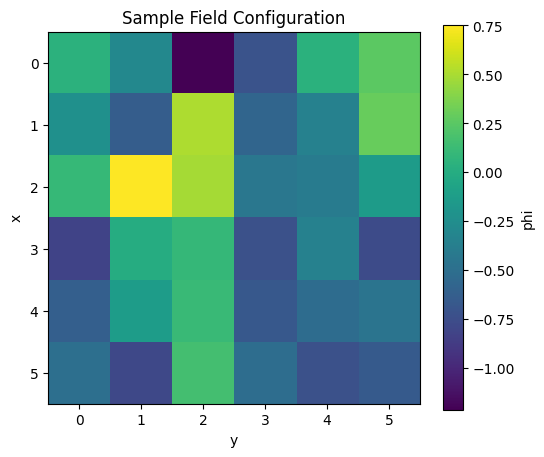

In [1]:
import numpy as np
from scipy.linalg import cholesky
import matplotlib.pyplot as plt



def sample_gaussian_field(nx, ny, m2):
    """
    Samples a field configuration phi from the Gaussian distribution defined by the action.
    
    Parameters:
    - nx, ny: Number of lattice points in the x and y directions.
    - m2: Mass squared parameter in the action.
    
    Returns:
    - phi: A (nx, ny) array representing the sampled field configuration.
    """
    N = nx * ny
    # Construct Laplacian
    L = construct_laplacian(nx, ny)
    # Kernel matrix K = -L + m^2 * I
    K = -L + m2 * np.eye(N)
    # Compute covariance matrix C = K^{-1}
    # For numerical stability and efficiency, we can solve K x = I instead of inverting
    # However, for small N, inversion is acceptable
    C = np.linalg.inv(K)
    # Cholesky decomposition: C = LL^T
    try:
        L_chol = cholesky(C, lower=True)
    except np.linalg.LinAlgError:
        raise ValueError("Covariance matrix is not positive definite.")
    # Sample standard normal variables
    z = np.random.randn(N)
    # Generate phi = L * z
    phi = L_chol @ z
    # Reshape to (nx, ny)
    phi = phi.reshape((nx, ny))
    return phi

def main():
    # Lattice size
    nx, ny = 6, 6
    m2 = 1.0  # Example mass squared parameter
    
    # Number of samples
    num_samples = 1000
    samples = []
    
    for _ in range(num_samples):
        phi = sample_gaussian_field(nx, ny, m2)
        samples.append(phi)
    
    samples = np.array(samples)
    
    # Compute observables, e.g., mean and variance at each site
    mean_phi = np.mean(samples, axis=0)
    var_phi = np.var(samples, axis=0)
    
    # Display results
    print("Mean of phi at each site:")
    print(mean_phi)
    
    print("\nVariance of phi at each site:")
    print(var_phi)
    
    # Plot a sample configuration
    plt.figure(figsize=(6,5))
    plt.imshow(samples[0], cmap='viridis', interpolation='none')
    plt.colorbar(label='phi')
    plt.title('Sample Field Configuration')
    plt.xlabel('y')
    plt.ylabel('x')
    plt.show()

if __name__ == "__main__":
    main()


In [14]:
import jax
from jax import vmap
from jax.random import PRNGKey, normal, multivariate_normal
import jax.numpy as jnp

batch_dot1 = jax.jit(vmap(jnp.dot, (0, 0), 0))
batch_dot2 = jax.jit(vmap(jnp.dot, (None, 0), 0))
def construct_covariance(nx, ny, m2):
    """
    Constructs the discrete Laplacian matrix for a 2D nx x ny lattice with periodic boundary conditions.

    Parameters:
    - nx, ny: Number of lattice points in the x and y directions.

    Returns:
    - L: The Laplacian matrix of size (nx*ny) x (nx*ny).
    """
    N = nx * ny
    La = jnp.eye(N)*(4 + m2)

    for x in range(nx):
        for y in range(ny):
            index = x * ny + y
            # Periodic boundary conditions: neighbors wrap around
            neighbors = [
                ((x + 1) % nx, y),  # Right
                ((x - 1) % nx, y),  # Left
                (x, (y + 1) % ny),  # Up
                (x, (y - 1) % ny)  # Down
            ]
            # Off-diagonal elements
            for (xn, yn) in neighbors:
                neighbor_index = xn * ny + yn
                La.at[index, neighbor_index].set(-1.0)
    cov = jnp.linalg.inv(La)
    detla = jnp.linalg.det(La)
    return La, cov, detla
def get_batch(num_samples, L, La, detla, cov, seed):
    #   Generate a batch of samples from a standard normal distribution.
    key = PRNGKey(seed)
    x = multivariate_normal(key, jnp.zeros(L**2), cov, shape = (num_samples, L**2))
    logp_x = -0.5*batch_dot1(x, batch_dot2(La, x))- L**2/2*jnp.log(2*jnp.pi) + jnp.log(detla)
    #logp_x = jnp.sum(jnp.log(normal_pdf(x)), axis=(1, 2))  # log probability of each sample

    return (x, logp_x, -x)


In [67]:
def construct_covariance(nx, ny, m2):
    """
    Constructs the discrete Laplacian matrix for a 2D nx x ny lattice with periodic boundary conditions.

    Parameters:
    - nx, ny: Number of lattice points in the x and y directions.

    Returns:
    - L: The Laplacian matrix of size (nx*ny) x (nx*ny).
    """
    N = nx * ny
    La = jnp.eye(N)*(4 - 2 * m2) * 2

    for x in range(nx):
        for y in range(ny):
            index = x * ny + y
            # Periodic boundary conditions: neighbors wrap around
            neighbors = [
                ((x + 1) % nx, y),  # Right
                ((x - 1) % nx, y),  # Left
                (x, (y + 1) % ny),  # Up
                (x, (y - 1) % ny)  # Down
            ]

            # Off-diagonal elements
            for (xn, yn) in neighbors:
                neighbor_index = xn * ny + yn
                La = La.at[index, neighbor_index].set(-2.0)
    cov = jnp.linalg.inv(La)
    detla = jnp.linalg.det(La)
    C = jnp.linalg.cholesky(cov)
    return  La, cov, detla, C

def get_batch(num_samples, L, La, C, seed, m2, lam):
    #   Generate a batch of samples from a standard normal distribution.
    key = PRNGKey(seed)
    x0 = normal(key, shape = (num_samples, L**2))
    x = batch_dot2(C, x0)
    logp_x = -0.5*jnp.sum(x0**2, axis = 1)
    diff_logp_x = -batch_dot2(La, x).reshape(num_samples, L, L)
    phi0 = jnp.tile(jnp.array([[jnp.sqrt(-m2/(2*lam)), -jnp.sqrt(-m2/(2*lam))]]), (num_samples, L**2//2))
    x = (x+phi0).reshape(num_samples, L, L)
    #logp_x = jnp.sum(jnp.log(normal_pdf(x)), axis=(1, 2))  # log probability of each sample

    return (x, logp_x, diff_logp_x)

In [68]:
La, cov, delta, C = construct_covariance(4, 4, -4)
get_batch(2, 4, La, C, 0, -4, 6.975)


(Array([[[ 0.4248816 , -0.3713979 ,  0.7162948 , -0.51850384],
         [ 0.67714   , -0.61886245,  0.49985927, -0.41221935],
         [ 0.5822863 , -0.2912336 ,  0.33778012, -0.47989172],
         [ 0.31675923, -0.31108916,  0.4654966 , -1.0819652 ]],
 
        [[ 0.5982867 , -0.6879954 ,  0.792336  , -0.65507483],
         [ 0.5006095 , -0.92141676,  0.42841592, -0.5222576 ],
         [ 0.6188073 , -0.5018831 ,  0.34777528, -0.60562336],
         [ 0.60264504, -0.84474003,  0.39567327, -0.36368716]]],      dtype=float32),
 Array([-7.2599936, -5.570796 ], dtype=float32),
 Array([[[ 2.8623457 , -3.5155094 , -4.1886587 , -1.1134331 ],
         [-3.447678  ,  3.0299249 ,  0.90087295, -2.6010375 ],
         [-0.67781454, -5.8816724 ,  5.1332474 , -2.482344  ],
         [ 4.4775147 , -5.146121  ,  1.0016317 , 12.683378  ]],
 
        [[-1.9870023 ,  2.9093115 , -7.2025166 ,  3.879643  ],
         [ 0.3837204 ,  8.7407875 ,  1.9624008 , -0.98067206],
         [-2.00837   , -2.405464  ,  3.9

In [69]:
print(La)

[[24. -2.  0. -2. -2.  0.  0.  0.  0.  0.  0.  0. -2.  0.  0.  0.]
 [-2. 24. -2.  0.  0. -2.  0.  0.  0.  0.  0.  0.  0. -2.  0.  0.]
 [ 0. -2. 24. -2.  0.  0. -2.  0.  0.  0.  0.  0.  0.  0. -2.  0.]
 [-2.  0. -2. 24.  0.  0.  0. -2.  0.  0.  0.  0.  0.  0.  0. -2.]
 [-2.  0.  0.  0. 24. -2.  0. -2. -2.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -2.  0.  0. -2. 24. -2.  0.  0. -2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -2.  0.  0. -2. 24. -2.  0.  0. -2.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -2. -2.  0. -2. 24.  0.  0.  0. -2.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -2.  0.  0.  0. 24. -2.  0. -2. -2.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -2.  0.  0. -2. 24. -2.  0.  0. -2.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -2.  0.  0. -2. 24. -2.  0.  0. -2.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -2. -2.  0. -2. 24.  0.  0.  0. -2.]
 [-2.  0.  0.  0.  0.  0.  0.  0. -2.  0.  0.  0. 24. -2.  0. -2.]
 [ 0. -2.  0.  0.  0.  0.  0.  0.  0. -2.  0.  0. -2. 24. -2.  0.]
 [ 0.  0. -2.  0.  0.  0.  0.  0.  0.  0. -2.  0.  0. -2. 24. 

In [70]:
print(detla)

43046736.0


In [50]:
jnp.linalg.eigvalsh(La+jnp.eye(16)*4)

Array([9.5367432e-07, 1.9999986e+00, 1.9999992e+00, 1.9999998e+00,
       2.0000002e+00, 3.9999983e+00, 3.9999995e+00, 3.9999998e+00,
       4.0000000e+00, 4.0000005e+00, 4.0000014e+00, 5.9999990e+00,
       5.9999995e+00, 6.0000000e+00, 6.0000005e+00, 8.0000019e+00],      dtype=float32)

In [52]:
jnp.tile(jnp.array([[1, -1]]), (2, 3))

Array([[ 1, -1,  1, -1,  1, -1],
       [ 1, -1,  1, -1,  1, -1]], dtype=int32)